# A Brief Introduction To GANs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

The generator is just a vanilla neural network model that takes a random input vector and outputs a 784-dim vector, which, when reshaped, becomes a 28*28 pixel image.

In [5]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

The discriminator is another neural network that takes the output of the previous network, a 784-dimensional vector, and outputs a probability between 0 and 1 that it came from the training dataset.

### Coding the Discriminator

In [6]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

### Compiling it into a GAN

In [7]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    
    # the output of the generator (an image)
    # a tensor  
    x = generator(gan_input)
    
    # get the output of the discriminator (probability if the image is real or not)
    # a tensor  
    gan_output = discriminator(x)
    
    # a model combiine generator and discriminator  
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

We now compile both models into a single adversarial network, setting the input as a 100-dimensional vector, and the output as the output of the discriminator.

In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10),
                          showflag=False, saveflag=True):
    # noise dim is (100, 100) 
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        # i in range(0,100)
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    if saveflag:
        plt.savefig('test_gan_generated_image_epoch_%d.png' % epoch)
    if showflag:
        plt.show()

### Training the GAN

In [9]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # create progress bar
            
            # Get a random set of input noise and images
            # noise dim is (128, 100) 
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            # image_batch dim is (128, 784)
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            # Concatenate two groups of image (real + fake)
            # dim: (256, 784)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            # dim: (256,)
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            # noise dim is (128, 100) 
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
            # why all one? because you want generator to get some real images
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 10 == 0:
            if e % 20 ==0:
                plot_generated_images(e, generator,showflag=True)
            else: 
                plot_generated_images(e, generator)

W0423 14:56:21.044894 140735559017344 deprecation_wrapper.py:118] From /Users/jcd/Library/Python/3.7/lib/python/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0423 14:56:21.053014 140735559017344 deprecation.py:323] From /Users/jcd/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0423 14:56:21.088517 140735559017344 deprecation.py:506] From /Users/jcd/Library/Python/3.7/lib/python/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set

--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:30, 15.30it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:30, 15.05it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:27, 17.04it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:23, 19.44it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:24, 19.02it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:25, 18.14it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:25, 18.31it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:30, 15.27it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:28, 16.23it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:28, 16.42it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:25, 18.21it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:26, 17.76it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:30, 15.13it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:25, 18.17it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:30, 15.46it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:28, 16.18it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:29, 15.66it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:28, 16.19it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:29, 15.74it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:29<00:00, 17.25it/s]


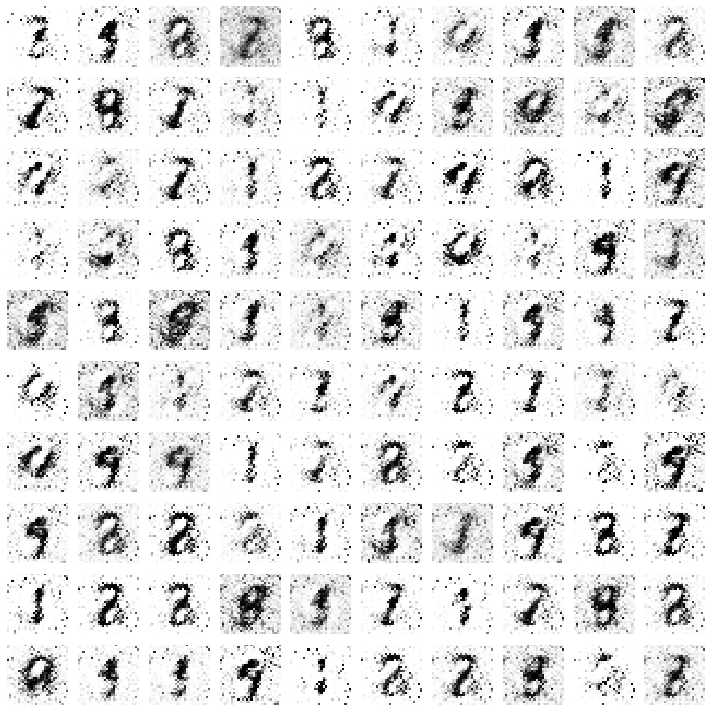

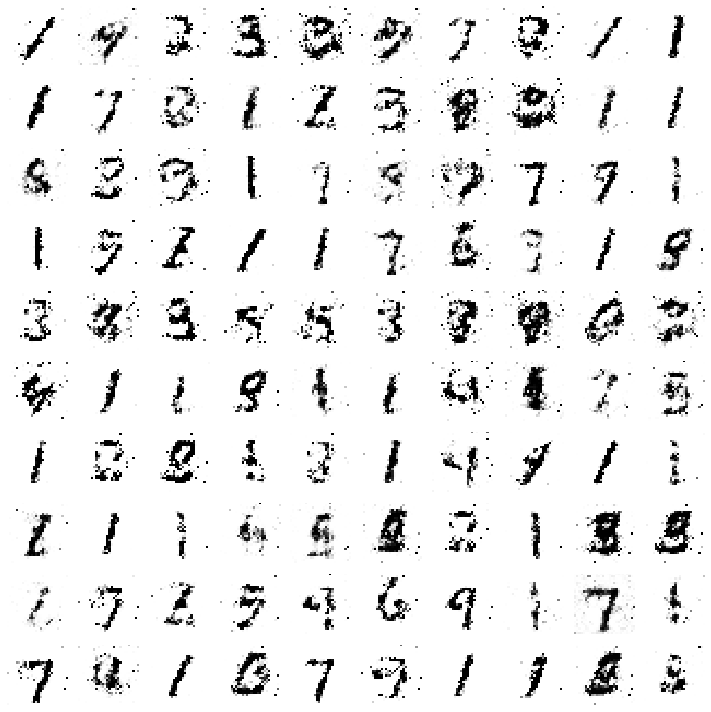

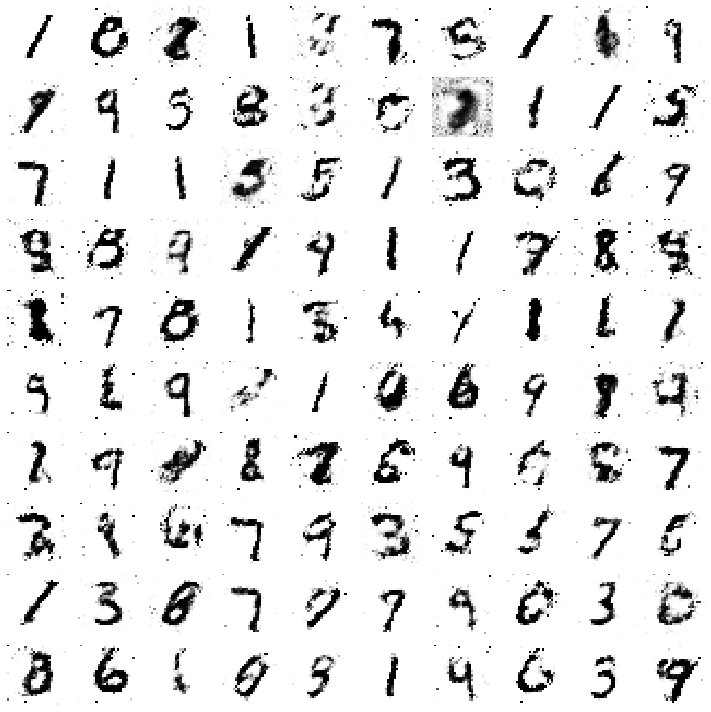

In [10]:
train(20, 128)

#### Q&A

ssl：certificate_verify_failed  
https://blog.csdn.net/yixieling4397/article/details/79861379
全局取消证书验证

In [ ]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context